In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import itertools
import pickle
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Load data
hdb_data = pd.read_csv("/content/merged_hdb_resale_data.csv")
# Step 4: Data Preprocessing
hdb_data['date'] = pd.to_datetime(hdb_data['month'])

<ipython-input-2-2e059e9ec487>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  hdb_data = pd.read_csv("/content/merged_hdb_resale_data.csv")


# **Price Trends Forecasting Model**

In [3]:
# Step 5: Forecasting Monthly Resale Prices with SARIMA
monthly_prices = hdb_data.groupby(hdb_data['date'].dt.to_period('M'))['resale_price'].mean()
monthly_prices.index = monthly_prices.index.to_timestamp()

# Split Data into Training and Test Sets
train_size = int(len(monthly_prices) * 0.8)  # 80% Training, 20% Testing
train, test = monthly_prices[:train_size], monthly_prices[train_size:]

# Define the parameter grid for (p,d,q) and (P,D,Q,s)
p = d = q = range(0, 3)  # Try values 0, 1, 2
P = D = Q = range(0, 2)  # Try values 0, 1
s = [12]  # Monthly seasonality

# Create all possible parameter combinations
param_combinations = list(itertools.product(p, d, q, P, D, Q, s))

# Store results
results = []

# Grid Search to find the best SARIMA model
for params in param_combinations:
    try:
        print(f"Testing SARIMA{params}")
        model = SARIMAX(
            train,
            order=(params[0], params[1], params[2]),  # (p,d,q)
            seasonal_order=(params[3], params[4], params[5], params[6]),  # (P,D,Q,s)
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        fit_model = model.fit()
        results.append((params, fit_model.aic))  # Store AIC score

    except Exception as e:
        print(f"Model failed for {params}: {e}")
        continue  # Skip invalid models

# Find the best model based on AIC
best_model_params, best_aic = min(results, key=lambda x: x[1])
print(f"\n✅ Best SARIMA model: SARIMA{best_model_params} with AIC = {best_aic}")

# ✅ Fit the Best SARIMA Model
best_sarima_model = SARIMAX(
    train,
    order=(best_model_params[0], best_model_params[1], best_model_params[2]),
    seasonal_order=(best_model_params[3], best_model_params[4], best_model_params[5], best_model_params[6]),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_price_result = best_sarima_model.fit()
print(sarima_price_result.summary())

# Fix Forecast Steps to Ensure Correct Time Period
last_date = monthly_prices.index[-1]
target_date = pd.Timestamp("2025-12-01")  # Forecast up to Dec 2025
forecast_steps = (target_date.year - last_date.year) * 12 + (target_date.month - last_date.month)
forecast_steps = max(forecast_steps, 1)  # Ensure forecast steps are positive

# ✅ Forecast Prices Until 2025
forecast_price = sarima_price_result.forecast(steps=forecast_steps)

# ✅ Ensure same length for evaluation
overlap_length = min(len(test), len(forecast_price))

# Compute evaluation only for matching timeframes
mae_price = mean_absolute_error(test[:overlap_length], forecast_price[:overlap_length])
mse_price = mean_squared_error(test[:overlap_length], forecast_price[:overlap_length])
rmse_price = np.sqrt(mse_price)

# ✅ Print Accuracy Metrics
print("SARIMA Model Accuracy for Resale Prices:")
print(f"MAE: {mae_price:.2f}")
print(f"MSE: {mse_price:.2f}")
print(f"RMSE: {rmse_price:.2f}")



Testing SARIMA(0, 0, 0, 0, 0, 0, 12)
Testing SARIMA(0, 0, 0, 0, 0, 1, 12)
Testing SARIMA(0, 0, 0, 0, 1, 0, 12)
Testing SARIMA(0, 0, 0, 0, 1, 1, 12)
Testing SARIMA(0, 0, 0, 1, 0, 0, 12)
Testing SARIMA(0, 0, 0, 1, 0, 1, 12)
Testing SARIMA(0, 0, 0, 1, 1, 0, 12)
Testing SARIMA(0, 0, 0, 1, 1, 1, 12)
Testing SARIMA(0, 0, 1, 0, 0, 0, 12)
Testing SARIMA(0, 0, 1, 0, 0, 1, 12)
Testing SARIMA(0, 0, 1, 0, 1, 0, 12)
Testing SARIMA(0, 0, 1, 0, 1, 1, 12)
Testing SARIMA(0, 0, 1, 1, 0, 0, 12)
Testing SARIMA(0, 0, 1, 1, 0, 1, 12)
Testing SARIMA(0, 0, 1, 1, 1, 0, 12)
Testing SARIMA(0, 0, 1, 1, 1, 1, 12)
Testing SARIMA(0, 0, 2, 0, 0, 0, 12)
Testing SARIMA(0, 0, 2, 0, 0, 1, 12)
Testing SARIMA(0, 0, 2, 0, 1, 0, 12)
Testing SARIMA(0, 0, 2, 0, 1, 1, 12)
Testing SARIMA(0, 0, 2, 1, 0, 0, 12)
Testing SARIMA(0, 0, 2, 1, 0, 1, 12)
Testing SARIMA(0, 0, 2, 1, 1, 0, 12)
Testing SARIMA(0, 0, 2, 1, 1, 1, 12)
Testing SARIMA(0, 1, 0, 0, 0, 0, 12)
Testing SARIMA(0, 1, 0, 0, 0, 1, 12)
Testing SARIMA(0, 1, 0, 0, 1, 0, 12)
T

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing SARIMA(1, 0, 0, 1, 0, 0, 12)
Testing SARIMA(1, 0, 0, 1, 0, 1, 12)
Testing SARIMA(1, 0, 0, 1, 1, 0, 12)
Testing SARIMA(1, 0, 0, 1, 1, 1, 12)
Testing SARIMA(1, 0, 1, 0, 0, 0, 12)
Testing SARIMA(1, 0, 1, 0, 0, 1, 12)
Testing SARIMA(1, 0, 1, 0, 1, 0, 12)
Testing SARIMA(1, 0, 1, 0, 1, 1, 12)
Testing SARIMA(1, 0, 1, 1, 0, 0, 12)
Testing SARIMA(1, 0, 1, 1, 0, 1, 12)
Testing SARIMA(1, 0, 1, 1, 1, 0, 12)
Testing SARIMA(1, 0, 1, 1, 1, 1, 12)
Testing SARIMA(1, 0, 2, 0, 0, 0, 12)
Testing SARIMA(1, 0, 2, 0, 0, 1, 12)
Testing SARIMA(1, 0, 2, 0, 1, 0, 12)
Testing SARIMA(1, 0, 2, 0, 1, 1, 12)
Testing SARIMA(1, 0, 2, 1, 0, 0, 12)
Testing SARIMA(1, 0, 2, 1, 0, 1, 12)
Testing SARIMA(1, 0, 2, 1, 1, 0, 12)
Testing SARIMA(1, 0, 2, 1, 1, 1, 12)
Testing SARIMA(1, 1, 0, 0, 0, 0, 12)
Testing SARIMA(1, 1, 0, 0, 0, 1, 12)
Testing SARIMA(1, 1, 0, 0, 1, 0, 12)
Testing SARIMA(1, 1, 0, 0, 1, 1, 12)
Testing SARIMA(1, 1, 0, 1, 0, 0, 12)
Testing SARIMA(1, 1, 0, 1, 0, 1, 12)
Testing SARIMA(1, 1, 0, 1, 1, 0, 12)
T

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing SARIMA(2, 0, 0, 0, 1, 0, 12)
Testing SARIMA(2, 0, 0, 0, 1, 1, 12)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing SARIMA(2, 0, 0, 1, 0, 0, 12)
Testing SARIMA(2, 0, 0, 1, 0, 1, 12)
Testing SARIMA(2, 0, 0, 1, 1, 0, 12)
Testing SARIMA(2, 0, 0, 1, 1, 1, 12)
Testing SARIMA(2, 0, 1, 0, 0, 0, 12)
Testing SARIMA(2, 0, 1, 0, 0, 1, 12)
Testing SARIMA(2, 0, 1, 0, 1, 0, 12)
Testing SARIMA(2, 0, 1, 0, 1, 1, 12)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing SARIMA(2, 0, 1, 1, 0, 0, 12)
Testing SARIMA(2, 0, 1, 1, 0, 1, 12)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing SARIMA(2, 0, 1, 1, 1, 0, 12)
Testing SARIMA(2, 0, 1, 1, 1, 1, 12)
Testing SARIMA(2, 0, 2, 0, 0, 0, 12)
Testing SARIMA(2, 0, 2, 0, 0, 1, 12)
Testing SARIMA(2, 0, 2, 0, 1, 0, 12)
Testing SARIMA(2, 0, 2, 0, 1, 1, 12)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing SARIMA(2, 0, 2, 1, 0, 0, 12)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing SARIMA(2, 0, 2, 1, 0, 1, 12)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing SARIMA(2, 0, 2, 1, 1, 0, 12)
Testing SARIMA(2, 0, 2, 1, 1, 1, 12)
Testing SARIMA(2, 1, 0, 0, 0, 0, 12)
Testing SARIMA(2, 1, 0, 0, 0, 1, 12)
Testing SARIMA(2, 1, 0, 0, 1, 0, 12)
Testing SARIMA(2, 1, 0, 0, 1, 1, 12)
Testing SARIMA(2, 1, 0, 1, 0, 0, 12)
Testing SARIMA(2, 1, 0, 1, 0, 1, 12)
Testing SARIMA(2, 1, 0, 1, 1, 0, 12)
Testing SARIMA(2, 1, 0, 1, 1, 1, 12)
Testing SARIMA(2, 1, 1, 0, 0, 0, 12)
Testing SARIMA(2, 1, 1, 0, 0, 1, 12)
Testing SARIMA(2, 1, 1, 0, 1, 0, 12)
Testing SARIMA(2, 1, 1, 0, 1, 1, 12)
Testing SARIMA(2, 1, 1, 1, 0, 0, 12)
Testing SARIMA(2, 1, 1, 1, 0, 1, 12)
Testing SARIMA(2, 1, 1, 1, 1, 0, 12)
Testing SARIMA(2, 1, 1, 1, 1, 1, 12)
Testing SARIMA(2, 1, 2, 0, 0, 0, 12)
Testing SARIMA(2, 1, 2, 0, 0, 1, 12)
Testing SARIMA(2, 1, 2, 0, 1, 0, 12)
Testing SARIMA(2, 1, 2, 0, 1, 1, 12)
Testing SARIMA(2, 1, 2, 1, 0, 0, 12)
Testing SARIMA(2, 1, 2, 1, 0, 1, 12)
Testing SARIMA(2, 1, 2, 1, 1, 0, 12)
Testing SARIMA(2, 1, 2, 1, 1, 1, 12)
Testing SARIMA(2, 2, 0, 0, 0, 0, 12)
T

# **Price Trends Forecasting Visualisation**

<ipython-input-4-69d99d266397>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.xticks(pd.date_range("2024-01-01", "2025-12-01", freq="M"), rotation=45)  # Show every month


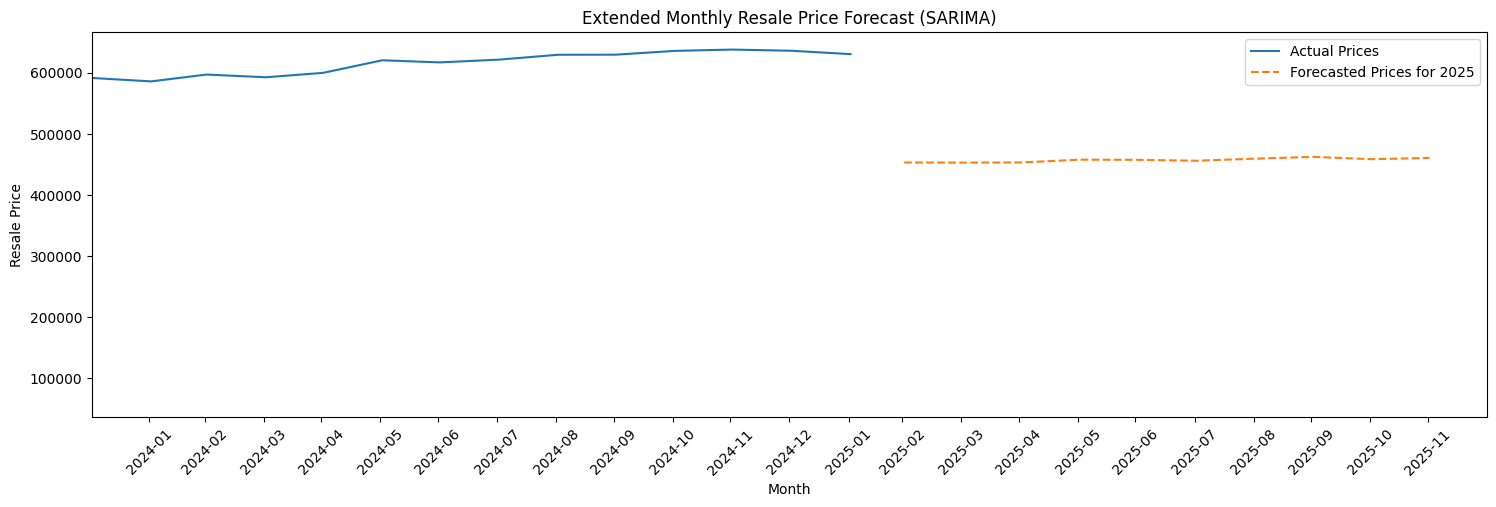

In [4]:
# ✅ Generate correct future date range
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')

# ✅ Plot the extended forecast
plt.figure(figsize=(18,5))
plt.plot(monthly_prices, label="Actual Prices")
plt.plot(future_dates, forecast_price, label="Forecasted Prices for 2025", linestyle="dashed")

# ✅ Set x-axis format and limits for every month
plt.xlim(pd.Timestamp("2024-01-01"), pd.Timestamp("2025-12-31"))  # Restrict x-axis to Jan 2024 - Dec 2025
plt.xticks(pd.date_range("2024-01-01", "2025-12-01", freq="M"), rotation=45)  # Show every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))  # Format as YYYY-MM

# Labels & Title
plt.title("Extended Monthly Resale Price Forecast (SARIMA)")
plt.xlabel("Month")
plt.ylabel("Resale Price")
plt.legend()
plt.show()

# **Resale Transactions Model**

In [5]:
# Resample data to get monthly transactions
monthly_transactions = hdb_data.resample('ME', on='date').size()

# Split Data into Training and Test Sets
train_size = int(len(monthly_transactions) * 0.8)  # 80% Training, 20% Testing
train_trans, test_trans = monthly_transactions[:train_size], monthly_transactions[train_size:]

# Define the parameter grid for (p,d,q) and (P,D,Q,s)
p = d = q = range(0, 3)  # Try values 0, 1, 2
P = D = Q = range(0, 2)  # Try values 0, 1
s = [12]  # Monthly seasonality

# Create all possible parameter combinations
param_combinations = list(itertools.product(p, d, q, P, D, Q, s))

# Store results
results = []

# Grid Search to find the best SARIMA model
for params in param_combinations:
    try:
        print(f"Testing SARIMA{params}")
        model = SARIMAX(
            train_trans,
            order=(params[0], params[1], params[2]),  # (p,d,q)
            seasonal_order=(params[3], params[4], params[5], params[6]),  # (P,D,Q,s)
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        fit_model = model.fit()
        results.append((params, fit_model.aic))  # Store AIC score

    except Exception as e:
        print(f"Model failed for {params}: {e}")
        continue  # Skip invalid models

# Find the best model based on AIC
best_model_params, best_aic = min(results, key=lambda x: x[1])
print(f"\n✅ Best SARIMA model: SARIMA{best_model_params} with AIC = {best_aic}")

# ✅ Fit the Best SARIMA Model
best_sarima_model = SARIMAX(
    train_trans,
    order=(best_model_params[0], best_model_params[1], best_model_params[2]),
    seasonal_order=(best_model_params[3], best_model_params[4], best_model_params[5], best_model_params[6]),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_trans_result = best_sarima_model.fit()
print(sarima_trans_result.summary())

# ✅ Fix Forecast Steps to Ensure Correct Time Period
last_date_trans = monthly_transactions.index[-1]
target_date_trans = pd.Timestamp("2025-12-01")  # Forecast up to Dec 2025

forecast_steps_trans = (target_date_trans.year - last_date_trans.year) * 12 + (target_date_trans.month - last_date_trans.month)
forecast_steps_trans = max(min(forecast_steps_trans, 24), 1)  # Limit forecast to 24 months

# ✅ Forecast Transactions Until 2025
forecast_trans = sarima_trans_result.forecast(steps=forecast_steps_trans)

# ✅ Ensure same length for evaluation
overlap_length_trans = min(len(test_trans), len(forecast_trans))

# Compute evaluation only for matching timeframes
mae_trans = mean_absolute_error(test_trans[:overlap_length_trans], forecast_trans[:overlap_length_trans])
mse_trans = mean_squared_error(test_trans[:overlap_length_trans], forecast_trans[:overlap_length_trans])
rmse_trans = np.sqrt(mse_trans)

# ✅ Print Accuracy Metrics
print("SARIMA Model Accuracy for Resale Transactions:")
print(f"MAE: {mae_trans:.2f}")
print(f"MSE: {mse_trans:.2f}")
print(f"RMSE: {rmse_trans:.2f}")



Testing SARIMA(0, 0, 0, 0, 0, 0, 12)
Testing SARIMA(0, 0, 0, 0, 0, 1, 12)
Testing SARIMA(0, 0, 0, 0, 1, 0, 12)
Testing SARIMA(0, 0, 0, 0, 1, 1, 12)
Testing SARIMA(0, 0, 0, 1, 0, 0, 12)
Testing SARIMA(0, 0, 0, 1, 0, 1, 12)
Testing SARIMA(0, 0, 0, 1, 1, 0, 12)
Testing SARIMA(0, 0, 0, 1, 1, 1, 12)
Testing SARIMA(0, 0, 1, 0, 0, 0, 12)
Testing SARIMA(0, 0, 1, 0, 0, 1, 12)
Testing SARIMA(0, 0, 1, 0, 1, 0, 12)
Testing SARIMA(0, 0, 1, 0, 1, 1, 12)
Testing SARIMA(0, 0, 1, 1, 0, 0, 12)
Testing SARIMA(0, 0, 1, 1, 0, 1, 12)
Testing SARIMA(0, 0, 1, 1, 1, 0, 12)
Testing SARIMA(0, 0, 1, 1, 1, 1, 12)
Testing SARIMA(0, 0, 2, 0, 0, 0, 12)
Testing SARIMA(0, 0, 2, 0, 0, 1, 12)
Testing SARIMA(0, 0, 2, 0, 1, 0, 12)
Testing SARIMA(0, 0, 2, 0, 1, 1, 12)
Testing SARIMA(0, 0, 2, 1, 0, 0, 12)
Testing SARIMA(0, 0, 2, 1, 0, 1, 12)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing SARIMA(0, 0, 2, 1, 1, 0, 12)
Testing SARIMA(0, 0, 2, 1, 1, 1, 12)
Testing SARIMA(0, 1, 0, 0, 0, 0, 12)
Testing SARIMA(0, 1, 0, 0, 0, 1, 12)
Testing SARIMA(0, 1, 0, 0, 1, 0, 12)
Testing SARIMA(0, 1, 0, 0, 1, 1, 12)
Testing SARIMA(0, 1, 0, 1, 0, 0, 12)
Testing SARIMA(0, 1, 0, 1, 0, 1, 12)
Testing SARIMA(0, 1, 0, 1, 1, 0, 12)
Testing SARIMA(0, 1, 0, 1, 1, 1, 12)
Testing SARIMA(0, 1, 1, 0, 0, 0, 12)
Testing SARIMA(0, 1, 1, 0, 0, 1, 12)
Testing SARIMA(0, 1, 1, 0, 1, 0, 12)
Testing SARIMA(0, 1, 1, 0, 1, 1, 12)
Testing SARIMA(0, 1, 1, 1, 0, 0, 12)
Testing SARIMA(0, 1, 1, 1, 0, 1, 12)
Testing SARIMA(0, 1, 1, 1, 1, 0, 12)
Testing SARIMA(0, 1, 1, 1, 1, 1, 12)
Testing SARIMA(0, 1, 2, 0, 0, 0, 12)
Testing SARIMA(0, 1, 2, 0, 0, 1, 12)
Testing SARIMA(0, 1, 2, 0, 1, 0, 12)
Testing SARIMA(0, 1, 2, 0, 1, 1, 12)
Testing SARIMA(0, 1, 2, 1, 0, 0, 12)
Testing SARIMA(0, 1, 2, 1, 0, 1, 12)
Testing SARIMA(0, 1, 2, 1, 1, 0, 12)
Testing SARIMA(0, 1, 2, 1, 1, 1, 12)
Testing SARIMA(0, 2, 0, 0, 0, 0, 12)
T

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing SARIMA(2, 0, 2, 1, 0, 0, 12)
Testing SARIMA(2, 0, 2, 1, 0, 1, 12)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing SARIMA(2, 0, 2, 1, 1, 0, 12)
Testing SARIMA(2, 0, 2, 1, 1, 1, 12)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing SARIMA(2, 1, 0, 0, 0, 0, 12)
Testing SARIMA(2, 1, 0, 0, 0, 1, 12)
Testing SARIMA(2, 1, 0, 0, 1, 0, 12)
Testing SARIMA(2, 1, 0, 0, 1, 1, 12)
Testing SARIMA(2, 1, 0, 1, 0, 0, 12)
Testing SARIMA(2, 1, 0, 1, 0, 1, 12)
Testing SARIMA(2, 1, 0, 1, 1, 0, 12)
Testing SARIMA(2, 1, 0, 1, 1, 1, 12)
Testing SARIMA(2, 1, 1, 0, 0, 0, 12)
Testing SARIMA(2, 1, 1, 0, 0, 1, 12)
Testing SARIMA(2, 1, 1, 0, 1, 0, 12)
Testing SARIMA(2, 1, 1, 0, 1, 1, 12)
Testing SARIMA(2, 1, 1, 1, 0, 0, 12)
Testing SARIMA(2, 1, 1, 1, 0, 1, 12)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing SARIMA(2, 1, 1, 1, 1, 0, 12)
Testing SARIMA(2, 1, 1, 1, 1, 1, 12)
Testing SARIMA(2, 1, 2, 0, 0, 0, 12)
Testing SARIMA(2, 1, 2, 0, 0, 1, 12)
Testing SARIMA(2, 1, 2, 0, 1, 0, 12)
Testing SARIMA(2, 1, 2, 0, 1, 1, 12)
Testing SARIMA(2, 1, 2, 1, 0, 0, 12)
Testing SARIMA(2, 1, 2, 1, 0, 1, 12)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing SARIMA(2, 1, 2, 1, 1, 0, 12)
Testing SARIMA(2, 1, 2, 1, 1, 1, 12)
Testing SARIMA(2, 2, 0, 0, 0, 0, 12)
Testing SARIMA(2, 2, 0, 0, 0, 1, 12)
Testing SARIMA(2, 2, 0, 0, 1, 0, 12)
Testing SARIMA(2, 2, 0, 0, 1, 1, 12)
Testing SARIMA(2, 2, 0, 1, 0, 0, 12)
Testing SARIMA(2, 2, 0, 1, 0, 1, 12)
Testing SARIMA(2, 2, 0, 1, 1, 0, 12)
Testing SARIMA(2, 2, 0, 1, 1, 1, 12)
Testing SARIMA(2, 2, 1, 0, 0, 0, 12)
Testing SARIMA(2, 2, 1, 0, 0, 1, 12)
Testing SARIMA(2, 2, 1, 0, 1, 0, 12)
Testing SARIMA(2, 2, 1, 0, 1, 1, 12)
Testing SARIMA(2, 2, 1, 1, 0, 0, 12)
Testing SARIMA(2, 2, 1, 1, 0, 1, 12)
Testing SARIMA(2, 2, 1, 1, 1, 0, 12)
Testing SARIMA(2, 2, 1, 1, 1, 1, 12)
Testing SARIMA(2, 2, 2, 0, 0, 0, 12)
Testing SARIMA(2, 2, 2, 0, 0, 1, 12)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing SARIMA(2, 2, 2, 0, 1, 0, 12)
Testing SARIMA(2, 2, 2, 0, 1, 1, 12)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing SARIMA(2, 2, 2, 1, 0, 0, 12)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing SARIMA(2, 2, 2, 1, 0, 1, 12)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing SARIMA(2, 2, 2, 1, 1, 0, 12)
Testing SARIMA(2, 2, 2, 1, 1, 1, 12)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



✅ Best SARIMA model: SARIMA(0, 2, 2, 0, 1, 1, 12) with AIC = 4384.626998007168
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  337
Model:             SARIMAX(0, 2, 2)x(0, 1, [1], 12)   Log Likelihood               -2188.313
Date:                              Tue, 11 Mar 2025   AIC                           4384.627
Time:                                      09:57:05   BIC                           4399.547
Sample:                                  01-31-1990   HQIC                          4390.593
                                       - 01-31-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1

# **Resale Transactions Forecasting Visualisation**

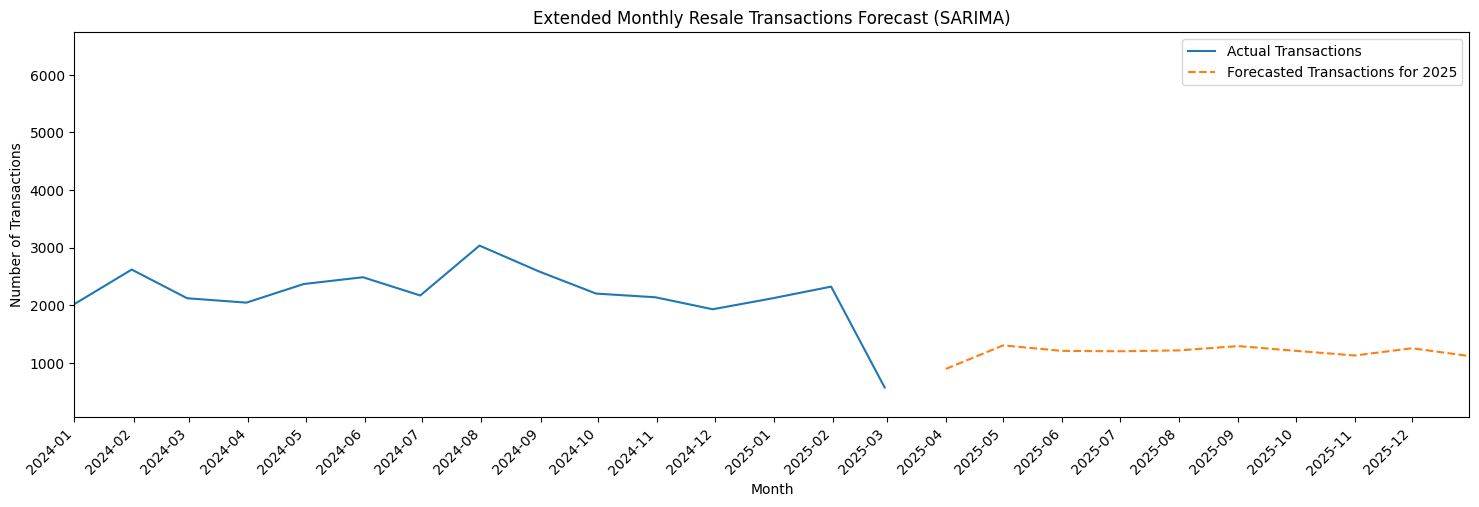

In [6]:
# ✅ Generate correct future date range
future_dates_trans = pd.date_range(start=last_date_trans + pd.DateOffset(months=1), periods=forecast_steps_trans, freq='MS')

# ✅ Plot the extended forecast
plt.figure(figsize=(18, 5))
plt.plot(monthly_transactions, label="Actual Transactions")
plt.plot(future_dates_trans, forecast_trans, label="Forecasted Transactions for 2025", linestyle="dashed")

# ✅ Set x-axis format and limits for **monthly display**
plt.xlim(pd.Timestamp("2024-01-01"), pd.Timestamp("2025-12-31"))  # Restrict x-axis to Jan 2024 - Dec 2025
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Show every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))  # Format as YYYY-MM

# ✅ Rotate the labels for better readability
plt.xticks(rotation=45, ha="right")

# ✅ Labels & Title
plt.title("Extended Monthly Resale Transactions Forecast (SARIMA)")
plt.xlabel("Month")
plt.ylabel("Number of Transactions")
plt.legend()
plt.show()

In [8]:
import joblib

# Save models
joblib.dump(sarima_price_result, "best_sarima_price.pkl")
joblib.dump(sarima_trans_result, "best_sarima_trans.pkl")

# Load models
best_sarima_price = joblib.load("best_sarima_price.pkl")
best_sarima_trans = joblib.load("best_sarima_trans.pkl")
